# Option 2 : Loading a Image Data with a custome `Dataset`

1. Want to be able  to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictonary from the Dataset


# Creating our custom dataset pipeline to replicate `torchvision.datasets.ImageFolder`

To create our own custom dataset, we want to:
1. Subclass `torch.utils.data.Dataset`
2. Init ourclass with a target directory (the directory we'd like to get data from) as well as a transform
3. Create several attributes:
    * paths - paths of our images
    * transform - the transform we'd like to use
    * classes - list of target classes
    * classes to idx - dict of our target classes mapped to integer labels
4. Create a function to `load_images()`, This function will open an image
5. Overwrite the `__len()__` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index  

In [40]:
import os
import pathlib
from PIL import Image
import matplotlib.pyplot as plt
import random

import torch
from torch.utils.data import DataLoader

from torch.utils.data import Dataset
from torchvision import transforms


from typing import Tuple, Dict, List


## 5.1 Creating helper function to get classes names
We want function to:
1. Get class names using os.scandir() to transverse a target directory
2. Raise an error if the class names are not found(if this happend, there might be something wrong with the directory structure)
3. Turn the class names into a dict and list and return them

In [10]:
# Setup path for target directory
train_root = pathlib.Path('D:\courses\DS&ML Course\Machine learning notebooks\Youtube note books\Data\pizza_steak_sushi_20_perecent/train')
test_root = pathlib.Path('D:\courses\DS&ML Course\Machine learning notebooks\Youtube note books\Data\pizza_steak_sushi_20_perecent/test')
target_directory  = train_root

# Get class names from target directory
print(f"Target directory : {target_directory}")
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target directory : D:\courses\DS&ML Course\Machine learning notebooks\Youtube note books\Data\pizza_steak_sushi_20_perecent\train


['pizza', 'steak', 'sushi']

In [6]:
def find_classes(directory : str) -> Tuple[List[str], Dict[str, int]]:
    """ Finds the class folder names in a target directory."""
    #1. get the class names by scaning the  target directory
    classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

    #2. Raise an error if class names could not be found 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any class in {directory}.... Please check file structure")
    
    #3. Create a directory of index labels (computers prefer numbers rather than strings as labels)
    classes_to_idx = {class_names : i for i, class_names in enumerate(classes)}
    return classes, classes_to_idx


In [7]:
find_classes(train_root)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [9]:
# Write a custome dataset class
from torch.utils.data import Dataset
import pathlib
# 1.Subclass torch.util.data.Dataset
class ImageFolderCustome(Dataset):
    #2.initialize our custom dataset
    def __init__(self,
                target_dir:str,
                transform = None):
        #3.Create class attributes
        #3.1 creating paths list to all image paths
        self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
        #3.2 create transform attribute
        self.transform = transform
        #3.3 create class and class to idx attributes
        self.classes, self.class_to_idx = find_classes(target_dir)
    #3.4 Create a function to load images
    def load_image(self, index:int) -> Image.Image :
        """ Image an image via a path and return it"""
        image_path = self.paths[index]
        return Image.open(image_path)
    # 4.Overwrite __len__() method
    def __len__(self) -> int:
        """returns the total number of samples"""
        return len(self.paths)
    
    # 5.Overwrite __getitem__() method
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        """Returns one sample of data, data and label (X, y)"""
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format : data_folder/class_name/image.jpg
        class_idx = self.class_to_idx[class_name]

        # Transforms if necessary 
        if self.transform:
            img = self.transform(img)
        return img, class_idx


In [11]:
# tran transformation pipeline
train_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(p = 0.5),
    transforms.ToTensor()
])

# test transformation pipeline
test_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [12]:
train_dataset = ImageFolderCustome(target_dir= train_root,
                                   transform= train_transform
                                   )
test_dataset = ImageFolderCustome(target_dir = test_root,
                                  transform = test_transform
                                  )


In [13]:
img, label = train_dataset[0]

img.shape

torch.Size([3, 64, 64])

In [15]:
train_dataset.classes, train_dataset.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [37]:
# Create a function to display random images 
def display_random_images(dataset : Dataset,
                          classes : List[str] = None,
                          n :int = 10,
                          display_shape :bool = True,
                          seed : int = None):
    #2. Adjust display of n to maximize it to 10
    if n > 10:
        n = 10
        display_shape = False
        print(f"For display, purposes, n shouldn't be larger than 10, setting n to 10 and removing display shape.")
    #3.set the random seed to reproducability
    if seed:
        random.seed(seed)
    #4. Get random sample index
    random_sample_idxs = random.sample(range(len(dataset)), k = n)
    
    
    #5.Setup matplotlib
    plt.figure(figsize = (15, 15))

    #6.loop to random sample indecies and plot them using matplotlib
    for i, random_sample_idx in enumerate(random_sample_idxs):
        image, label = dataset[random_sample_idx]

        #7. Adjust image for matplotlib convert from (C, H, W) tp (H, W,C) 
        target_adjusted_image = image.permute([1, 2, 0])

        #8.Plot the images
        plt.subplot(1, n, i+1)
        plt.imshow(target_adjusted_image)
        plt.axis(False)
        if classes:
            title = f"Class:{classes[label]}"
            if display_shape:
                title = title + f"\nShape : {target_adjusted_image.shape}"
        plt.title(title,fontsize = 10)
                

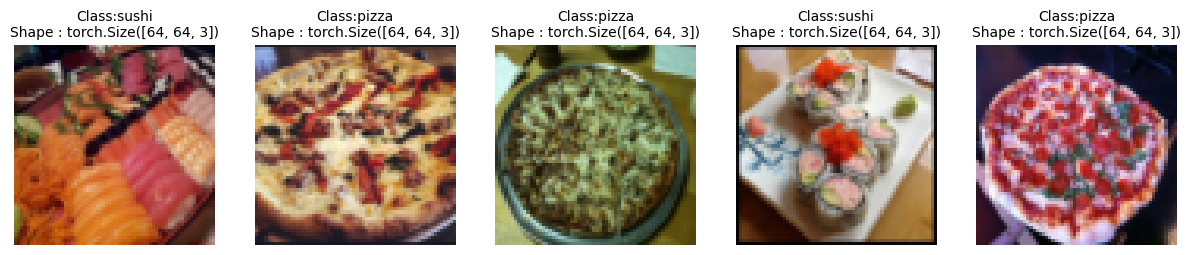

In [39]:
# Display random Images from our CustomeImageFolder
display_random_images(dataset = train_dataset,
                      classes = train_dataset.classes,
                      n = 5,
                      seed = 42)

In [46]:
# Turn CustomImageFolder Dataset into Dataloaders

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size = 32,
                              shuffle=True)

test_dataloader = DataLoader(dataset = test_dataset,
                             batch_size = 32,
                             shuffle = True)

In [49]:
# iterating across train dataloader to see one batch sample and corresponding labels
batch_sample, batch_label = next(iter(train_dataloader))

print(f"batch size shape : {batch_sample.shape}")
print(f"Corresponding labels : {batch_label}")

batch size shape : torch.Size([32, 3, 64, 64])
Corresponding labels : tensor([1, 1, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 0, 0, 2, 1, 1, 2, 1])
